In [7]:
!pip install scikit-image

     ---------------------------------------- 0.0/23.7 MB ? eta -:--:--
     ---------------------------------------- 0.2/23.7 MB 3.5 MB/s eta 0:00:07
      --------------------------------------- 0.5/23.7 MB 4.1 MB/s eta 0:00:06
     -- ------------------------------------- 1.2/23.7 MB 6.1 MB/s eta 0:00:04
     -- ------------------------------------- 1.6/23.7 MB 5.2 MB/s eta 0:00:05
     --- ------------------------------------ 2.4/23.7 MB 6.0 MB/s eta 0:00:04
     ---- ----------------------------------- 2.8/23.7 MB 6.1 MB/s eta 0:00:04
     ----- ---------------------------------- 3.2/23.7 MB 6.4 MB/s eta 0:00:04
     ----- ---------------------------------- 3.2/23.7 MB 6.1 MB/s eta 0:00:04
     ----- ---------------------------------- 3.2/23.7 MB 6.1 MB/s eta 0:00:04
     --------- ------------------------------ 5.4/23.7 MB 6.3 MB/s eta 0:00:03
     ---------- ----------------------------- 6.4/23.7 MB 6.4 MB/s eta 0:00:03
     ----------- ---------------------------- 6.9/23.7 MB 6


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [11]:
path = glob('images/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In the above code, we individually take each file and parse into xml.etree and find the object -> bndbox. Then we extract xmin,xmax,ymin,ymax and saved those values in the dictionary. After we convert it into a pandas data frame and save that into CSV file and save it in project folder as shown below.

In [12]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

filepath  xmin  xmax  ymin  ymax
0    images\N1.xml  1093  1396   645   727
1  images\N100.xml   134   301   312   350
2  images\N101.xml    31   139   128   161
3  images\N102.xml   164   316   216   243
4  images\N103.xml   813  1067   665   724

With the above code, we successfully extract the diagonal position of each image and convert the data from an unstructured to a structured format.You can have A look data above. Now also extract the respective image filename of the XML.

In [13]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('images',filename_image)
    return filepath_image
getFilename(filename)

'images\\N1.jpeg'

In [14]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random check

['images\\N1.jpeg',
 'images\\N100.jpeg',
 'images\\N101.jpeg',
 'images\\N102.jpeg',
 'images\\N103.jpeg',
 'images\\N104.jpeg',
 'images\\N105.jpeg',
 'images\\N106.jpeg',
 'images\\N107.jpeg',
 'images\\N108.jpeg']

### VERIFY THE DATA

As till now we did the manual process it is important to verify the information is we got is valid or not. For that just verify the bounding box is appearing properly for a given image. Here I consider the image N2.jpeg and the corresponding diagonal position can found in df. Result you can see on *Figure 8*

In [27]:
file_path = image_path[87] #path of our image N2.jpeg
img = cv2.imread(file_path) #read the image
# xmin-1804/ymin-1734/xmax-2493/ymax-1882 
img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 8 - N2.jpeg with bounding box')
fig.add_shape(type='rect',x0=570, x1=830, y0=532, y1=460, xref='x', yref='y',line_color='cyan')

###  READ DATA

This is a very important step, in this process we will take each and every image and convert it into an array using OpenCV and resize the image into 224 x 224 which is the standard compatible size of the pre-trained transfer learning model.

In [28]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

### SPLIT TRAIN AND TEST SET

In [29]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

Now split the data into training and testing set using __sklearn__.

In [30]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

In [31]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

219055592/219055592 [==============================] - 25s 0us/step


Now compile the model and  have a look at our summary. Don't de surprise summary will be a bit massiv. The summary is textual and includes information about: The layers and their order in the model. The output shape of each layer. The number of parameters (weights) in each layer.

In [32]:
# Complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

### INCEPTION-RESNET-V2 TRAINING AND SAVE

In [ ]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,verbose=0,epochs=180,
                    validation_data=(x_test,y_test),callbacks=[tfb])

In [13]:
model.save('./object_detection.h5')

### MAKE PREDICTIONS

This is the final step in object detection. In this step, we will put it all together and get the prediction for a given image. First, I would like to try with one of my test pictures of car. Let load our model.

In [14]:
# Load model
model = tf.keras.models.load_model('./object_detection.h5')
print('Model loaded Sucessfully')

Model loaded Sucessfully


Next is loading our TEST picture with right path to it. I loaded some more images for this purpose  only - folder __TEST__.

In [15]:
path = 'TEST/TEST.jpeg'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # Convert into array and get the normalized output

# Size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)


Height of the image = 729
Width of the image = 901


Now we can have a look at our image *Figure 13*


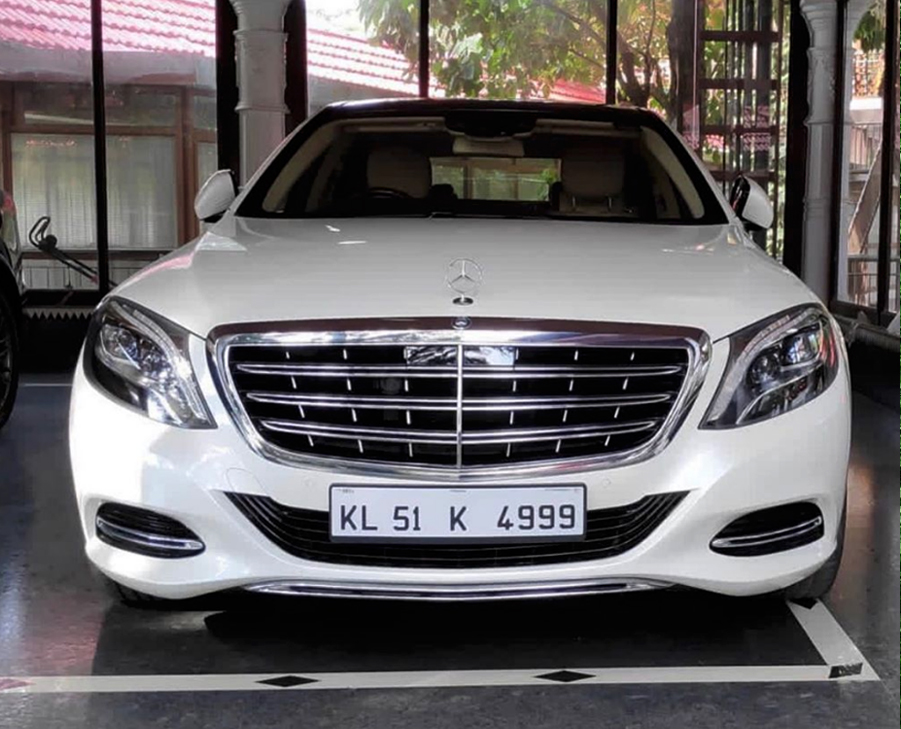

In [16]:
fig = px.imshow(image)
fig.update_layout(width=700, height=500,  margin=dict(l=10, r=10, b=10, t=10), xaxis_title='Figure 13 - TEST Image')

So, let's look into the shape of my image.

In [17]:
image_arr_224.shape

(224, 224, 3)

But in order to pass this image of a model, we need to provide the data in the dynamic fourth dimension. And what one indicates is a number of images. So here we are just passing only one image.

In [18]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

### DE-NORMALIZE THE OUTPUT

In [19]:
# Make predictions
coords = model.predict(test_arr)
coords

array([[0.35339227, 0.6454397 , 0.6641029 , 0.7467256 ]], dtype=float32)

We have got the output from the model and output what we got is the normalized output. So, what we need to do is to convert back into our original form values, which actually we did in during the training process, in the training process, we have the original form values and convert that normalized one. So basically, we will de-normalize the values back.

In [20]:
# Denormalize the values
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[318.40643814, 581.54115564, 484.13102281, 544.36297613]])

### BOUNDING BOX

Now we will draw bounding box on top of the image. I just want to provide the two diagonal points. Let's make use of these points and let's draw the rectangle box.

In [21]:
coords = coords.astype(np.int32)
coords

array([[318, 581, 484, 544]], dtype=int32)

In [22]:
# Draw bounding on top the image
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(318, 484) (581, 544)



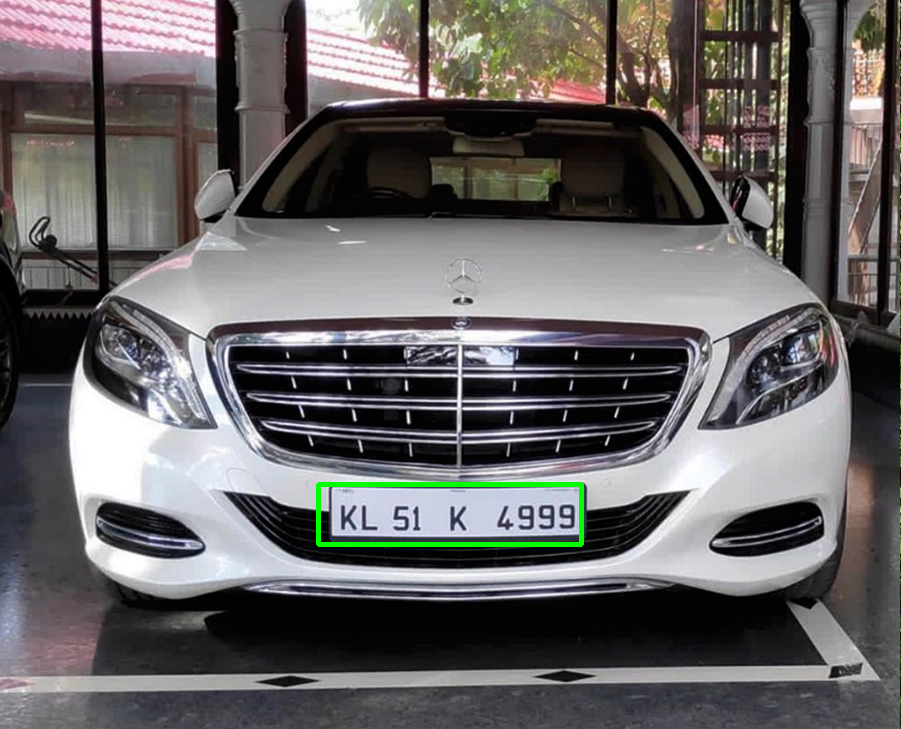

In [23]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10))

### CREATE PIPELINE

Now what we'll do, let's put it all together in one place and create function. And in the end visualize it. Our output will return image and coordinates of bounding box.

(318, 484) (581, 544)



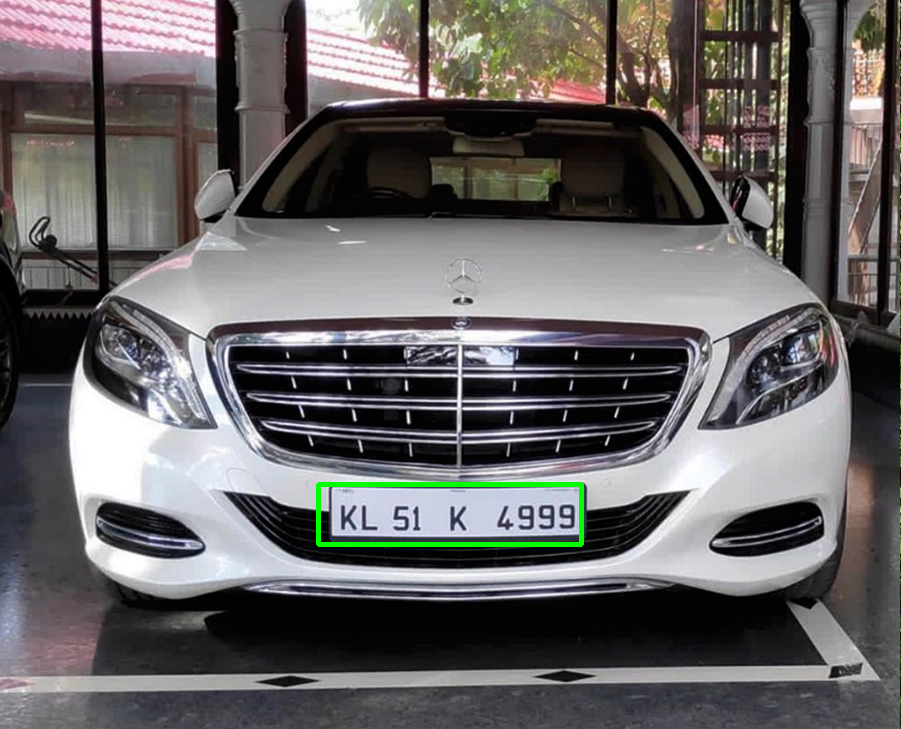

In [24]:
# Create pipeline
path = 'TEST/TEST.jpeg'
def object_detection(path):
    
    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    
    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # Make predictions
    coords = model.predict(test_arr)
    
    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

### EXTRACT NUMBER PLATE TEXT FROM IMAGE

Firstly, we will load our image and convert to array. Crop our bounding box with coordinates of it. We will identify region of interest (ROI) and have look at our cropped imag


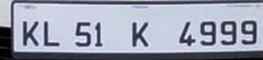

In [25]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 15 Cropped image')

With use of tesseract, we will extract the text from the mage.


In [26]:
# extract text from image
text = pt.image_to_string(roi)
print(text)

HKL 51 K 4999



Obviously, we didn't get the proper text, but at least you can able to get 90 percent of the information. It just an example and again will need to say that as more data than better prediction. We will come to that point in future. What I realize here: First of all we don't have much data, to resolve this problem and I added to this topic more sets almost the same data sets from other kagglers posted recently. Secondly i don't see that this model perfom well be honest with you, but full process which has beed done gave as a chance to undertand concept, we will buld another model with help of YOLO and where we can see how it perfom to conpear our results. Second of of Tesseract, I already explain some limetation of it, but image preproccessing can be another topic and it could even requre to build AI on it. So, now I want you to show how to build simple web and next step after it we will start with new model.